###### The probability of an eccentricity GIVEN that a planet is transiting (P(e|b)) and the probability of a longitude of periastron GIVEN that a planet is transiting (P(w|b)) are different than P(e) and P(w).

https://academic.oup.com/mnras/article/444/3/2263/1053015

In [313]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from astropy.table import Table
import astropy.units as u
import matplotlib

# Using `batman` to create & fit fake transit
import batman

# Using astropy BLS and scipy curve_fit to fit transit
from astropy.timeseries import BoxLeastSquares
from scipy.optimize import curve_fit

import scipy.optimize as opt

# Using emcee & corner to find and plot (e, w) distribution
import emcee
import corner

# And importing `photoeccentric`
import photoeccentric as ph

# Random stuff
import scipy.constants as c
from scipy.stats import rayleigh
import os

from pathlib import Path

%load_ext autoreload
%autoreload 2

%matplotlib inline

plt.rcParams['figure.figsize'] = [12, 8]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [314]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [315]:
def mode(dist):

    """Gets mode of a histogram.

    Parameters
    ----------
    dist: array
        Distribution

    Returns
    -------
    mode: float
        Mode
    """

    #n, bins = np.histogram(dist, bins=np.linspace(np.nanmin(dist), np.nanmax(dist), 100))
    n, bins = np.histogram(dist, bins=np.linspace(np.nanmin(dist), np.nanmax(dist), 500))
    mode = bins[np.nanargmax(n)]
    return mode

# UNIFORM DISTRIBUTION

In [316]:
trueew_uniform = pd.read_csv('/Users/ssagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/notebooks/plots_hpg/uniform/fitew.txt', index_col=False)

In [317]:
distpath_uniform = "/Users/ssagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/notebooks/plots_hpg/uniform/edists/"

paths = sorted(Path(distpath_uniform).iterdir(), key=os.path.getmtime)
paths.reverse()

In [318]:
edist_uniform = []

for file in paths:
    fname = os.path.join(distpath_uniform, file)
    try:
        edist_uniform.append(np.genfromtxt(fname, delimiter=','))
    except UnicodeDecodeError:
        pass

es_uniform = []
ws_uniform = []
gs_uniform = []

for i in range(len(edist_uniform)):

    es_uniform.append(edist_uniform[i][:,0])
    ws_uniform.append(edist_uniform[i][:,1])
    gs_uniform.append(edist_uniform[i][:,2])

Text(0.5, 1.0, 'All E distributions (sample ~800)')

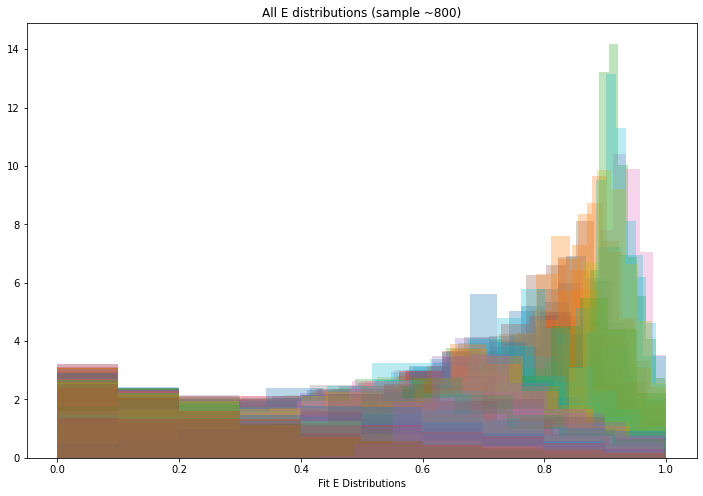

In [319]:
es_uniform = np.array(es_uniform)

fite = []

plt.cla()

for i in range(len(es_uniform)):
    fite.append(mode(es_uniform[i]))
    plt.hist(es_uniform[i], alpha=0.3, density=True, stacked=True);
    
fite = np.array(fite)
plt.xlabel('Fit E Distributions')
plt.title('All E distributions (sample ~800)')

Text(0.5, 1.0, 'All w distributions (sample ~800)')

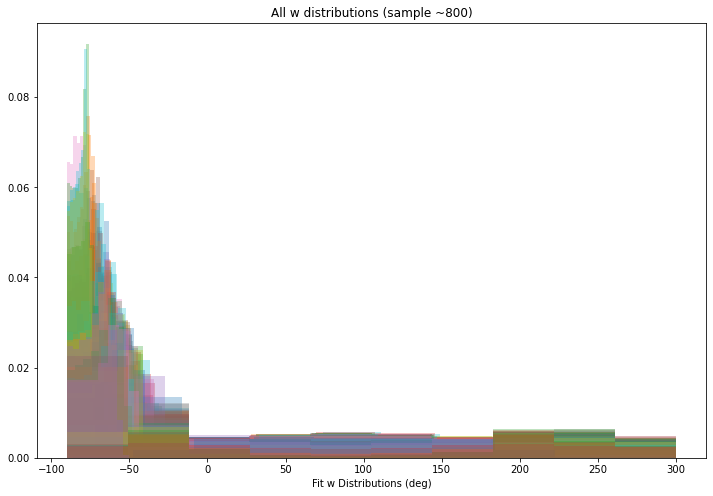

In [320]:
ws_uniform = np.array(ws_uniform)

fitw = []

plt.cla()

for i in range(len(ws_uniform)):
    fitw.append(mode(ws_uniform[i]))
    plt.hist(ws_uniform[i], alpha=0.3, density=True, stacked=True);
    

fitw = np.array(fitw)
plt.xlabel('Fit w Distributions (deg)')
plt.title('All w distributions (sample ~800)')

In [321]:
truew = np.array(trueew_uniform['truew'])
truee = np.array(trueew_uniform['truee'])

In [322]:
for i in range(len(fitw)):
    if fitw[i] > 90:
        fitw[i] = fitw[i]-180

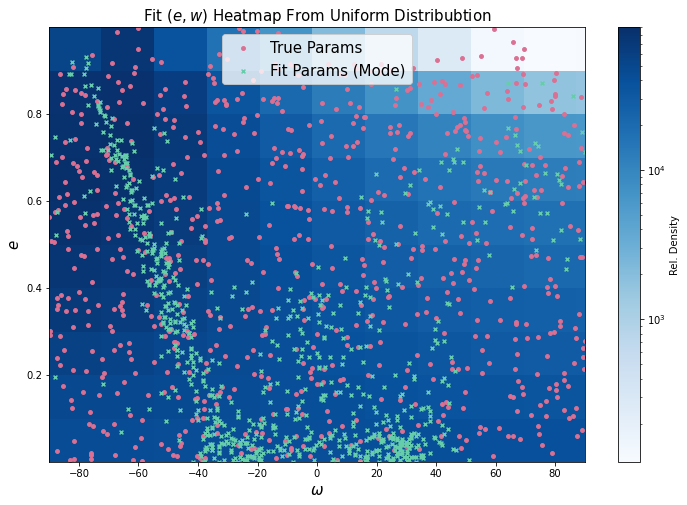

In [323]:
plt.cla()

fz = 15

plt.hist2d(ws_uniform.flatten(), es_uniform.flatten(), bins=[22,10], cmap='Blues', norm=matplotlib.colors.LogNorm());
plt.colorbar(label='Rel. Density')

plt.scatter(truew, truee, marker='o', s=15, c='palevioletred', label='True Params')
plt.scatter(fitw, fite, marker='x', s=15, c='mediumaquamarine', label='Fit Params (Mode)')

plt.legend(fontsize=fz)

plt.xlim(-90, 90)
plt.xlabel('$\omega$', fontsize=fz)
plt.ylabel('$e$', fontsize=fz)
plt.title('Fit $(e,w)$ Heatmap From Uniform Distribubtion', fontsize=fz)

plt.savefig('Fit_EW_heatmap_uniform.png')

Text(0, 0.5, 'e')

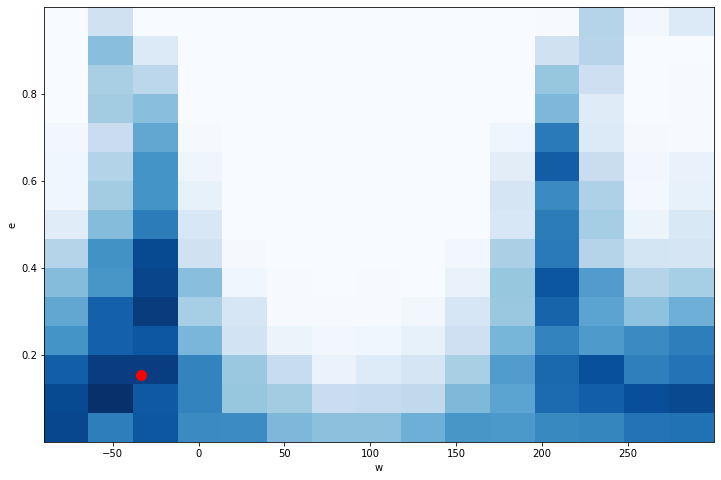

In [324]:
plt.hist2d(ws_uniform[0], es_uniform[0], cmap='Blues', bins=15);
#plt.contour(np.transpose(counts), extent=[wbins.min(),wbins.max(),ebins.min(),ebins.max()],linewidths=3, cmap='Blues')
plt.scatter(truew[0], truee[0], c='r', s=100)

plt.xlabel('w')
plt.ylabel('e')

In [325]:
wuniform = np.random.uniform(-90, 90, 50)


inds = []

for i in range(len(wuniform)):
    inds.append(int(np.argwhere(fitw == find_nearest(fitw, wuniform[i]))[0]))


euni = truee[inds].flatten()
wuni = truew[inds].flatten()

efuni = fite[inds].flatten()
wfuni = fitw[inds].flatten()
    
edistuni = np.array(es_uniform[inds]).flatten()

wdistuni = np.array(ws_uniform[inds]).flatten()

In [326]:
def deltallike(g, gerr, truee, truew, fite, fitw):
    
    model_fit = (1+e*np.sin(w*(np.pi/180.)))/np.sqrt(1-e**2)
    sigma2_fit = gerr ** 2
    loglike_fit = -0.5 * np.sum((g - model_fit) ** 2 / sigma2_fit + np.log(sigma2_fit))
    
    
    model_true = (1+truee*np.sin(truew*(np.pi/180.)))/np.sqrt(1-truee**2)
    sigma2_true = gerr ** 2
    loglike_true = -0.5 * np.sum((g - model_true) ** 2 / sigma2_true + np.log(sigma2_true))
    
    llike = np.abs(loglike_fit-loglike_true)
    return llike

In [327]:
llike = []

for i in range(len(truee)):

    g = ph.mode(gs_uniform[i])
    e = ph.mode(es_uniform[i])
    w = ph.mode(ws_uniform[i])
    
    gerr = np.nanstd(gs_uniform[i])
    
    llike.append(deltallike(g, gerr, truee[i], truew[i], e, w))
    
    
llike = np.array(llike)

llikeuni = llike[inds]

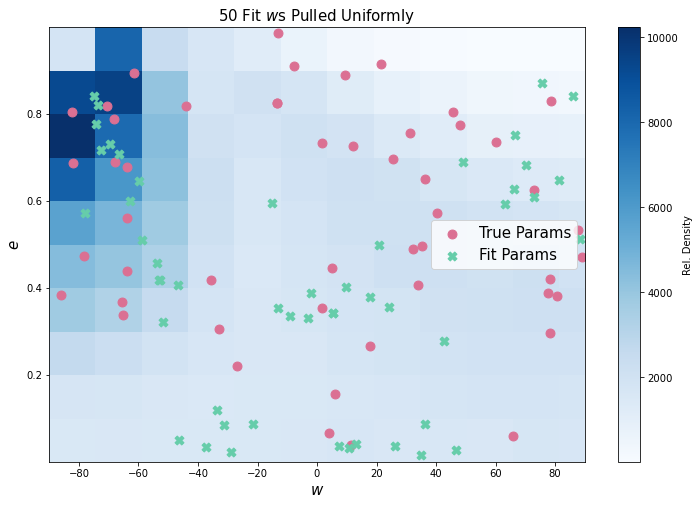

In [334]:
plt.cla()

fz = 15

plt.hist2d(wdistuni, edistuni, bins=[25,10], cmap='Blues')#, norm=matplotlib.colors.LogNorm());
plt.xlim(-90, 90)
#plt.clim(vmax=4000.0)
plt.colorbar(label='Rel. Density')
plt.scatter(wuni, euni, marker='o', s=80, c='palevioletred', label='True Params')
plt.scatter(wfuni, efuni, marker='X', s=80, c='mediumaquamarine', label='Fit Params')

plt.legend(fontsize=fz)

plt.xlabel('$w$', fontsize=fz)
plt.ylabel('$e$', fontsize=fz)
plt.title('50 Fit $w$s Pulled Uniformly', fontsize=fz)

plt.savefig('heatmap_truee_uniformwfit_50.png')

In [335]:
euni,wuni

(array([0.38447505, 0.38782369, 0.30431521, 0.5712626 , 0.73450354,
        0.68724748, 0.80464174, 0.2662855 , 0.80409108, 0.4887055 ,
        0.62478408, 0.42011366, 0.91058949, 0.41886787, 0.49638642,
        0.1564256 , 0.77465177, 0.35353333, 0.82998186, 0.89411468,
        0.36806038, 0.81812434, 0.03945323, 0.8885017 , 0.43778831,
        0.38136371, 0.44543318, 0.78757427, 0.98660391, 0.29670938,
        0.65124488, 0.91360676, 0.53255915, 0.81691833, 0.67818533,
        0.55950898, 0.82458087, 0.68960873, 0.4074106 , 0.69513595,
        0.33697653, 0.05867458, 0.75642629, 0.47298307, 0.73375534,
        0.47087767, 0.72542253, 0.06596338, 0.219799  , 0.82458087]),
 array([-86.091639  ,  77.75303431, -32.95416556,  40.34185696,
         60.14659111, -82.15795674, -82.43062712,  17.89474971,
         45.66813199,  32.35266976,  72.74788105,  78.42801261,
         -7.66670883, -35.74767135,  35.41872263,   5.93052304,
         48.00426487,   1.58120087,  78.4887825 , -61.35390567

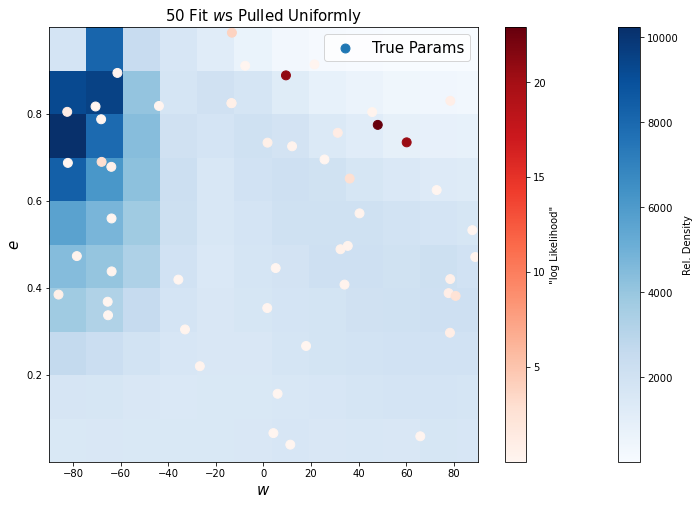

In [336]:
plt.cla()

fz = 15

plt.hist2d(wdistuni, edistuni, bins=[25,10], cmap='Blues')#, norm=matplotlib.colors.LogNorm());
plt.xlim(-90, 90)
#plt.clim(vmax=4000.0)
plt.colorbar(label='Rel. Density')


plt.scatter(wuni, euni, marker='o', s=80, c=llikeuni, label='True Params', cmap='Reds')#, norm=matplotlib.colors.LogNorm())
plt.colorbar(label='"log Likelihood"')

#plt.scatter(wfuni, efuni, marker='X', s=80, c='mediumaquamarine', label='Fit Params')

plt.legend(fontsize=fz)

plt.xlabel('$w$', fontsize=fz)
plt.ylabel('$e$', fontsize=fz)
plt.title('50 Fit $w$s Pulled Uniformly', fontsize=fz)

plt.savefig('heatmap_truee_uniformwfit50_llike.png')

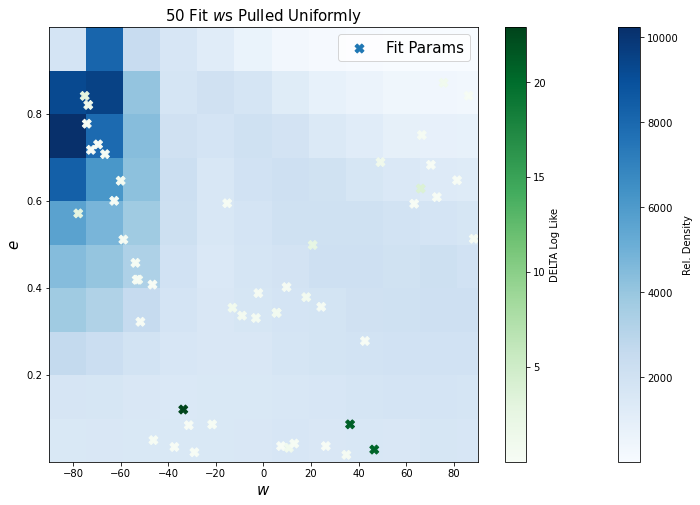

In [337]:
plt.cla()

fz = 15

plt.hist2d(wdistuni, edistuni, bins=[25,10], cmap='Blues')#, norm=matplotlib.colors.LogNorm());
plt.xlim(-90, 90)
#plt.clim(vmax=4000.0)
plt.colorbar(label='Rel. Density')


plt.scatter(wfuni, efuni, marker='X', s=80, c=llikeuni, label='Fit Params', cmap='Greens')#, norm=matplotlib.colors.LogNorm())
plt.colorbar(label='DELTA Log Like')

plt.legend(fontsize=fz)

plt.xlabel('$w$', fontsize=fz)
plt.ylabel('$e$', fontsize=fz)
plt.title('50 Fit $w$s Pulled Uniformly', fontsize=fz)

plt.savefig('heatmap_truee_uniformwfit50_lfitslike.png')

<ipython-input-338-0df879438d1b>:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Reds"))
  cmap.set_bad(color='white')


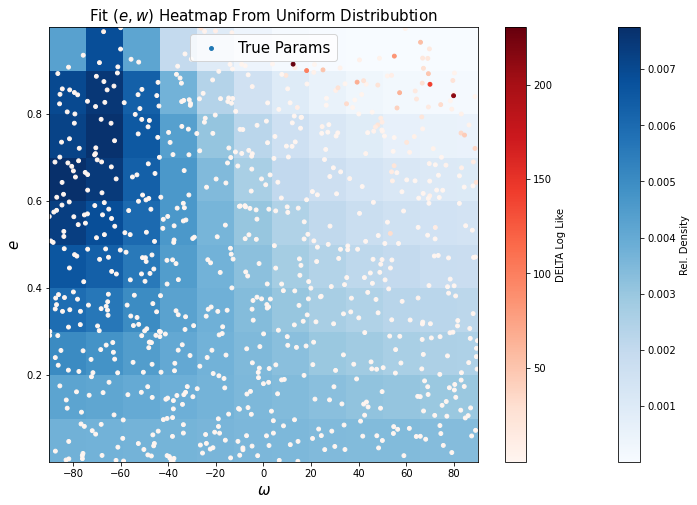

In [338]:
plt.cla()

fz = 15

cmap = plt.cm.Reds
cmap.set_bad(color='white')

plt.hist2d(ws_uniform.flatten(), es_uniform.flatten(), bins=[25,10], cmap='Blues', density=True)#, norm=matplotlib.colors.LogNorm());
plt.colorbar(label='Rel. Density')

plt.scatter(truew, truee, marker='o', s=15, c=llike, label='True Params', cmap=cmap)#, norm=matplotlib.colors.LogNorm())
plt.colorbar(label='DELTA Log Like')
#plt.scatter(fitw, fite, marker='x', s=15, c='mediumaquamarine', label='Fit Params')

plt.legend(fontsize=fz)

plt.xlim(-90, 90)
plt.xlabel('$\omega$', fontsize=fz)
plt.ylabel('$e$', fontsize=fz)
plt.title('Fit $(e,w)$ Heatmap From Uniform Distribubtion', fontsize=fz)

plt.savefig('heatmap_llike_colorbar.png')

<ipython-input-340-d7d26c93dd7b>:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Greens"))
  cmap.set_bad(color='white')


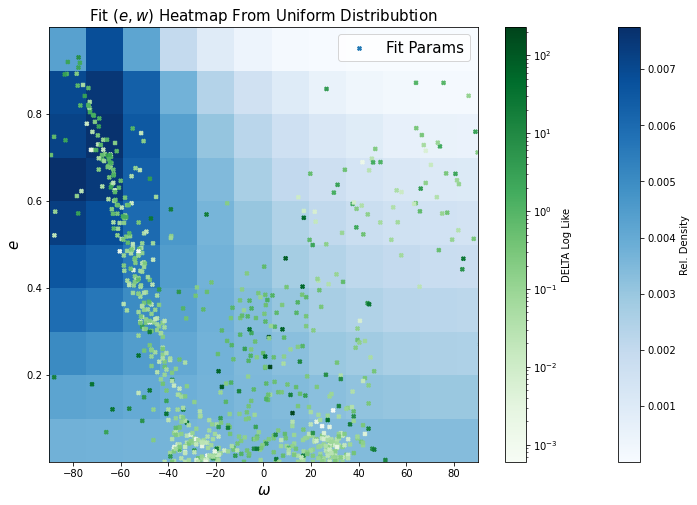

In [340]:
plt.cla()

fz = 15

cmap = plt.cm.Greens
cmap.set_bad(color='white')

plt.hist2d(ws_uniform.flatten(), es_uniform.flatten(), bins=[25,10], cmap='Blues', density=True)#, norm=matplotlib.colors.LogNorm());
plt.colorbar(label='Rel. Density')

#plt.scatter(truew, truee, marker='o', s=15, c=llike, label='True Params', cmap='Reds', norm=matplotlib.colors.LogNorm())
plt.scatter(fitw, fite, marker='X', s=15, c=llike, label='Fit Params', cmap=cmap, norm=matplotlib.colors.LogNorm())
plt.colorbar(label='DELTA Log Like')
plt.legend(fontsize=fz)

plt.xlim(-90, 90)
plt.xlabel('$\omega$', fontsize=fz)
plt.ylabel('$e$', fontsize=fz)
plt.title('Fit $(e,w)$ Heatmap From Uniform Distribubtion', fontsize=fz)

plt.savefig('heatmap_llike_colorbar_fit.png')

Text(0.5, 1.0, 'e distribution')

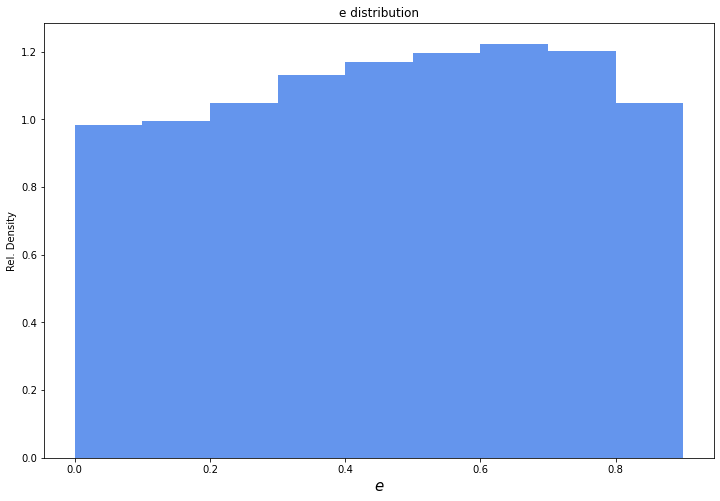

In [341]:
plt.hist(edistuni, color='cornflowerblue', bins=np.arange(0, 1, 0.1), density=True, stacked=True)
plt.xlabel('$e$', fontsize=fz)
plt.ylabel('Rel. Density')
plt.title('e distribution')

# GAUSSIAN DISTRIBUTION

In [342]:
# e_rand = np.random.normal(0.4, 0.1, size=n)
# w_rand = np.random.normal(0.0, 45.0, size=n)

In [343]:
trueew_gaussian = pd.read_csv('/Users/ssagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/notebooks/plots_hpg/gaussian/fitew.txt', index_col=False)

distpath_gaussian = "/Users/ssagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/notebooks/plots_hpg/gaussian/edists/"

paths = sorted(Path(distpath_gaussian).iterdir(), key=os.path.getmtime)
paths.reverse()

edist_gaussian = []

for file in paths:
    fname = os.path.join(distpath_gaussian, file)
    try:
        edist_gaussian.append(np.genfromtxt(fname, delimiter=','))
    except UnicodeDecodeError:
        pass

es_gaussian = []
ws_gaussian = []
gs_gaussian = []

for i in range(len(edist_gaussian)):

    es_gaussian.append(edist_gaussian[i][:,0])
    ws_gaussian.append(edist_gaussian[i][:,1])
    gs_gaussian.append(edist_gaussian[i][:,2])

es_gaussian = np.array(es_gaussian)

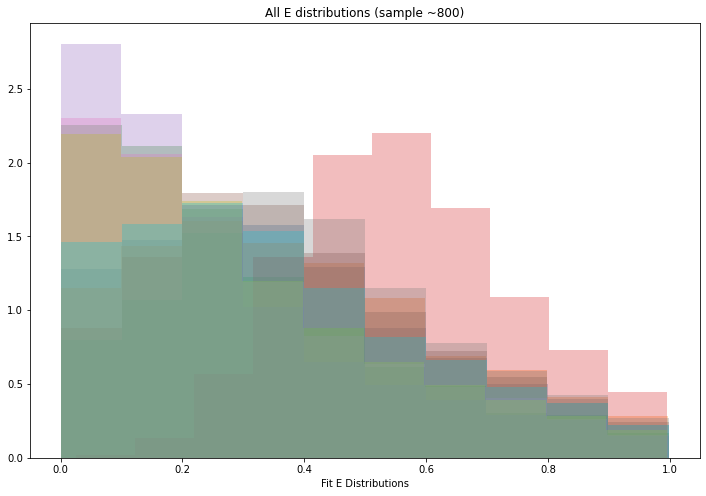

In [344]:
fite = []

plt.cla()

for i in range(len(es_gaussian)):
    fite.append(mode(es_gaussian[i]))
    plt.hist(es_gaussian[i], alpha=0.3, density=True, stacked=True);
    
fite = np.array(fite)
plt.xlabel('Fit E Distributions')
plt.title('All E distributions (sample ~800)')

ws_gaussian = np.array(ws_gaussian)

Text(0.5, 1.0, 'All w distributions (sample ~800)')

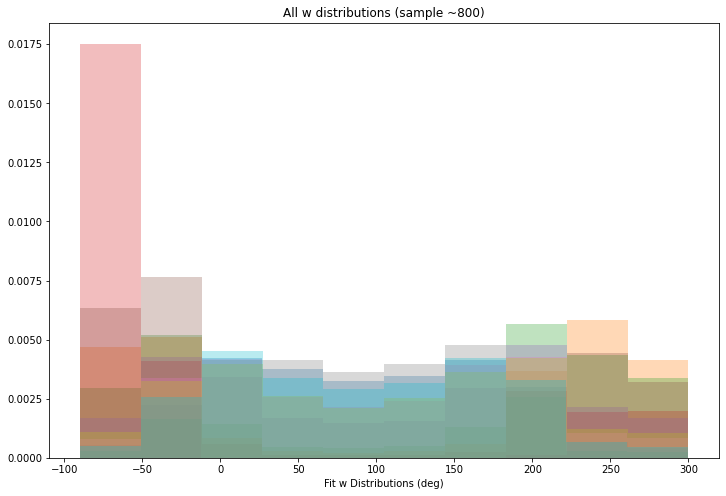

In [345]:
fitw = []

plt.cla()

for i in range(len(ws_gaussian)):
    fitw.append(mode(ws_gaussian[i]))
    plt.hist(ws_gaussian[i], alpha=0.3, density=True, stacked=True);
    

fitw = np.array(fitw)
plt.xlabel('Fit w Distributions (deg)')
plt.title('All w distributions (sample ~800)')

In [296]:
truew = np.array(trueew_gaussian['truew'])
truee = np.array(trueew_gaussian['truee'])

len(truee)

10

In [297]:
for i in range(len(fitw)):
    if fitw[i] > 90:
        fitw[i] = fitw[i]-180

<ipython-input-298-541bb83adc7d>:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Blues"))
  cmap.set_bad(color='white')


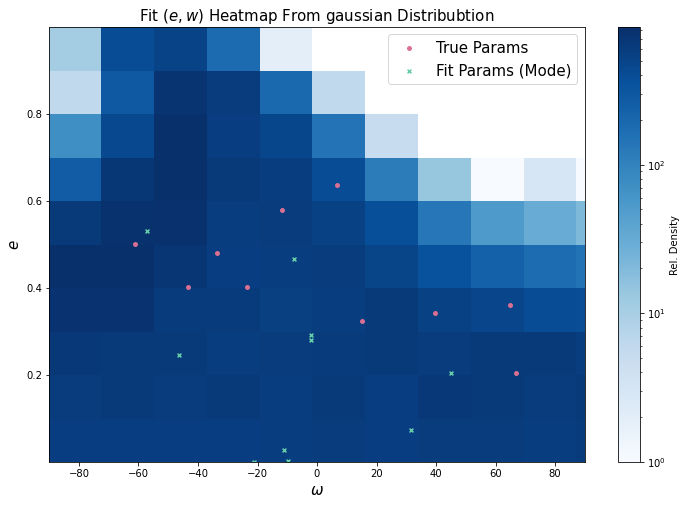

In [298]:
plt.cla()

fz = 15

cmap = plt.cm.Blues
cmap.set_bad(color='white')

plt.hist2d(ws_gaussian.flatten(), es_gaussian.flatten(), bins=[22,10], cmap=cmap, norm=matplotlib.colors.LogNorm());
plt.colorbar(label='Rel. Density')

plt.scatter(truew, truee, marker='o', s=15, c='palevioletred', label='True Params')
plt.scatter(fitw, fite, marker='x', s=15, c='mediumaquamarine', label='Fit Params (Mode)')

plt.legend(fontsize=fz)

plt.xlim(-90, 90)
plt.xlabel('$\omega$', fontsize=fz)
plt.ylabel('$e$', fontsize=fz)
plt.title('Fit $(e,w)$ Heatmap From gaussian Distribubtion', fontsize=fz)

plt.savefig('Fit_EW_heatmap_gaussian.png')

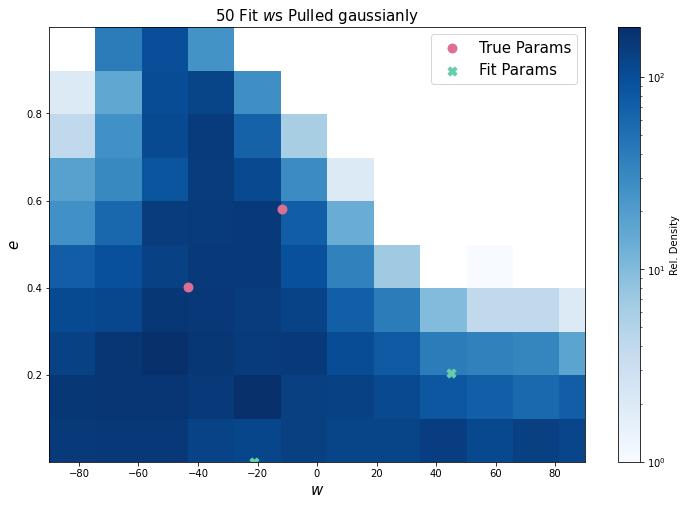

In [299]:
wgaussian = np.random.uniform(-90, 90, 2)


inds = []

for i in range(len(wgaussian)):
    inds.append(int(np.argwhere(fitw == find_nearest(fitw, wgaussian[i]))[0]))


euni = truee[inds].flatten()
wuni = truew[inds].flatten()

efuni = fite[inds].flatten()
wfuni = fitw[inds].flatten()
    
edistuni = np.array(es_gaussian[inds]).flatten()

wdistuni = np.array(ws_gaussian[inds]).flatten()

llike = []

for i in range(len(fite)):

    counts, wbins, ebins = np.histogram2d(ws_gaussian[i], es_gaussian[i], bins=15);
    
    llike.append(counts[np.digitize(truew[i], wbins)-1, np.digitize(truee[i], ebins)-1])
    
llike = np.array(llike)

llikeuni = llike[inds]

plt.cla()

fz = 15

plt.hist2d(wdistuni, edistuni, bins=[25,10], cmap='Blues', norm=matplotlib.colors.LogNorm());
plt.xlim(-90, 90)
#plt.clim(vmax=4000.0)
plt.colorbar(label='Rel. Density')
plt.scatter(wuni, euni, marker='o', s=80, c='palevioletred', label='True Params')
plt.scatter(wfuni, efuni, marker='X', s=80, c='mediumaquamarine', label='Fit Params')

plt.legend(fontsize=fz)

plt.xlabel('$w$', fontsize=fz)
plt.ylabel('$e$', fontsize=fz)
plt.title('50 Fit $w$s Pulled gaussianly', fontsize=fz)

plt.savefig('heatmap_truee_gaussianwfit_50.png')